# Import modules and load DEM from datacube

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid

import warnings
warnings.filterwarnings('ignore')

In [2]:
import datacube
prod_dc = datacube.Datacube()

In [3]:
dem_query = {
#Fitzroy river, WA
'y': (-18.8, -18.1), 
'x': (124.9, 125.5),

#Lake Eucumbene
#'y': (-36.252, -35.895),
#'x': (148.435, 148.874),

#Lake Eucumbene - Kozzie
#'y': (-36.8, -35.8),
#'x': (147.9, 148.9),

'crs': 'EPSG:4326',

#'output_crs': 'EPSG: 4326',
#'resolution': (0.0002777777777777778, 0.0002777777777777778)

'output_crs': 'EPSG: 3577',
'resolution': (30, 30)
}
dem = prod_dc.load(product = 'srtm_dem1sv1_0', measurements=['dem_h'], **dem_query)

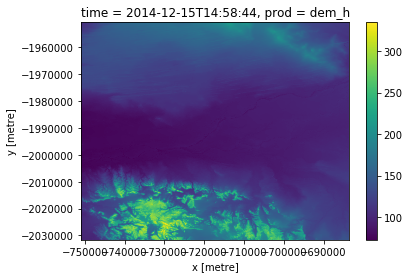

In [4]:
dem_array = dem.isel(time=0).to_array(dim='prod')

if dem_array.shape[0]>1:
    dem_array.plot(col='prod', figsize=(5*dem_array.shape[0],4));
else:
    dem_array.squeeze().plot.imshow();

# Instatiate a grid and add DEM-H as raster

In [5]:
import pyproj
from affine import Affine

In [6]:
if 'x' in dem.coords:
    xres = dem.x.values[1]-dem.x.values[0]
    yres = dem.y.values[1]-dem.y.values[0]
    x_ref = dem.x.values[0]
    y_ref = dem.y.values[0]
else:
    xres = dem.longitude.values[1]-dem.longitude.values[0]
    yres = dem.latitude.values[1]-dem.latitude.values[0]
    x_ref = dem.longitude.values[0]
    y_ref = dem.latitude.values[0]

In [7]:
grid = Grid(nodata = np.nan, 
            crs = pyproj.Proj('+init=epsg:%s'%dem.dem_h.attrs['crs'].epsg))

In [8]:
grid.add_gridded_data(dem.dem_h.where(dem.dem_h!=dem.dem_h.attrs['nodata']).values.squeeze(),
                      data_name = 'dem', affine = Affine(xres, 0, x_ref, 0, yres, y_ref),
                      shape = dem.dem_h.values.squeeze().shape, 
                      nodata = np.nan, 
                      crs = pyproj.Proj('+init=epsg:%s'%dem.dem_h.attrs['crs'].epsg))

# Inspect DEM and condition (if necessary)

# Calculate flow direction and accumulation

In [9]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
grid.flowdir(data='dem', out_name='dir', dirmap=dirmap)

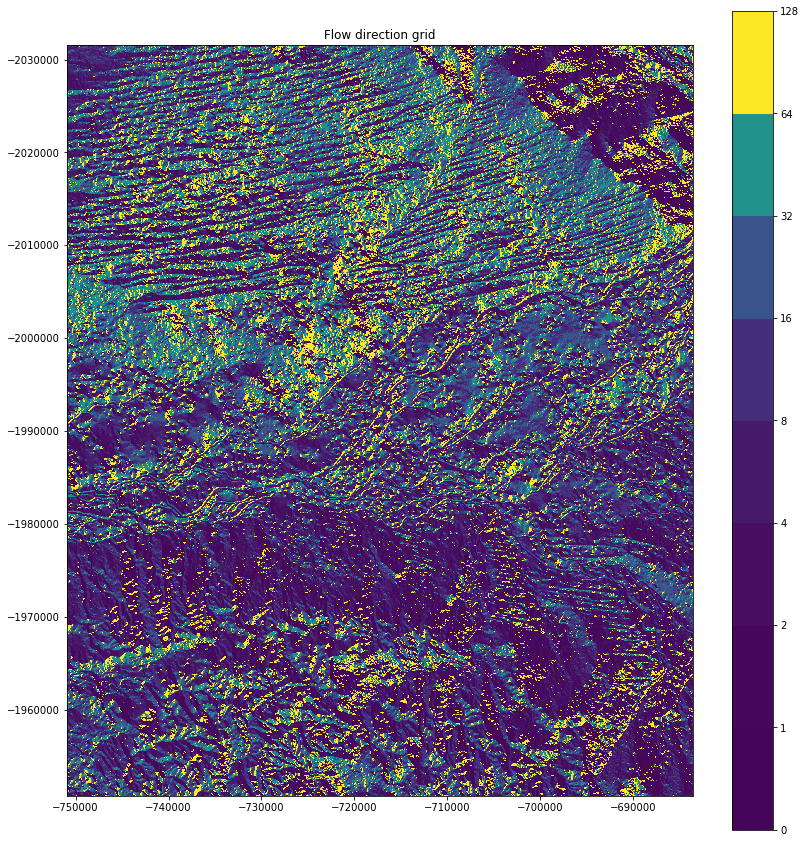

In [10]:
fig = plt.figure(figsize=(12,12))
fig.patch.set_alpha(0)
plt.imshow(grid.dir, extent=grid.extent, cmap='viridis', zorder=2, origin='lower')
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.title('Flow direction grid')
plt.grid(zorder=-1)
plt.tight_layout()

In [11]:
grid.accumulation(data='dir', out_name='acc')

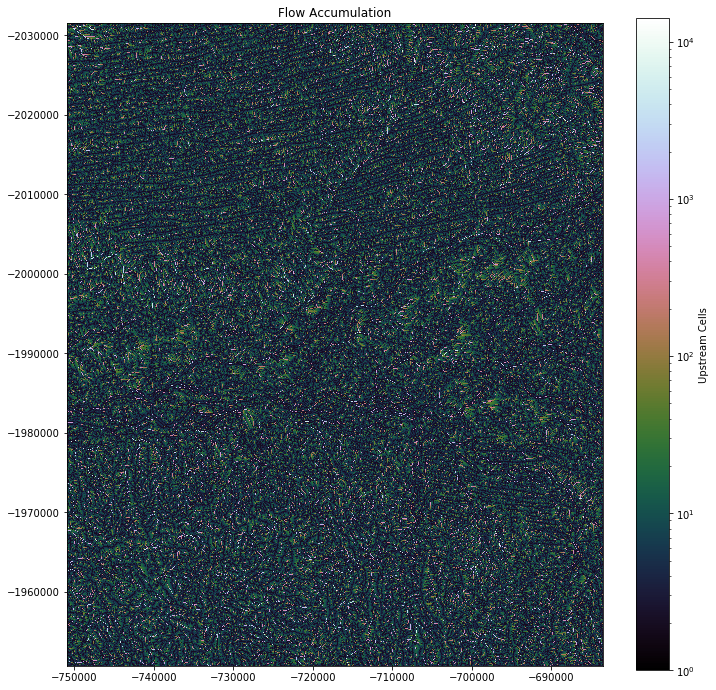

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc +1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()), origin='lower')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation');

# Catchment

# Compute height above nearest drainage (HAND)

26.0


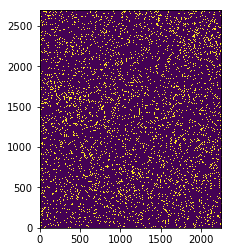

In [13]:
acc_thresh = np.nanpercentile(grid.acc, 90)
print(acc_thresh)
plt.imshow(grid.acc>acc_thresh, origin='lower');

In [14]:
hand = grid.compute_hand('dir', 'dem', grid.acc > acc_thresh, inplace=False)

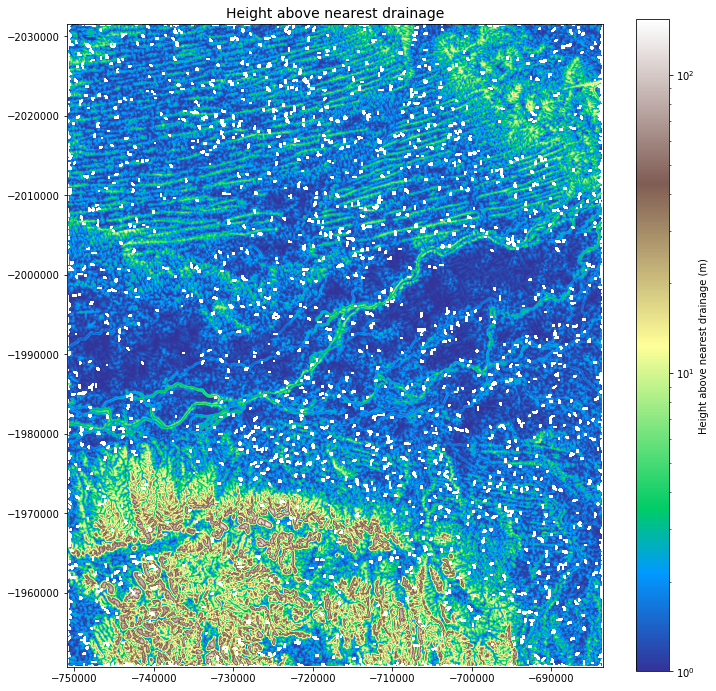

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
plt.imshow(hand + 1, zorder=1, cmap='terrain', interpolation='bilinear',
           extent=grid.extent, origin='lower',
           norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hand)))
plt.colorbar(label='Height above nearest drainage (m)');
plt.title('Height above nearest drainage', size=14);

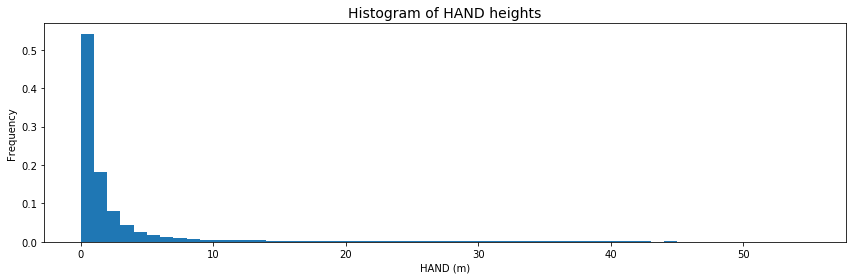

In [16]:
hand_max = np.nanpercentile(hand,99)
fig, ax = plt.subplots(figsize=(12, 4))
h = plt.hist(hand[~np.isnan(hand) & (hand!=0)], bins=np.arange(0,hand_max,1), normed=True)
plt.title('Histogram of HAND heights', size=14)
plt.ylabel('Frequency')
plt.xlabel('HAND (m)')
plt.tight_layout()

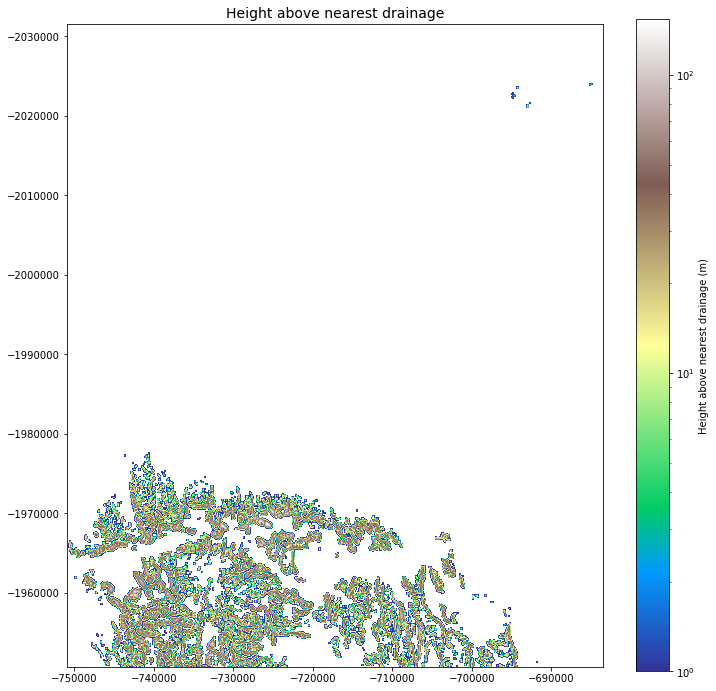

In [17]:
fig, ax = plt.subplots(figsize=(12,12))
plt.imshow(np.where(hand>20, hand + 1, 0), zorder=1, cmap='terrain', interpolation='bilinear',
           extent=grid.extent, origin='lower',
           norm=colors.LogNorm(vmin=1, vmax=np.nanmax(hand)))
plt.colorbar(label='Height above nearest drainage (m)');
plt.title('Height above nearest drainage', size=14);
#plt.savefig('hand_mask_20.png', bbox_inches='tight')

# Compare to water detection

In [18]:
wofs = prod_dc.load(product='wofs_filtered_summary', group_by='solar_day', **dem_query).isel(time=0)

In [19]:
wofs['hand_mask'] = ('y','x'), hand >20

In [20]:
wofs.hand_mask

<xarray.DataArray 'hand_mask' (y: 2695, x: 2245)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] 2018-08-07T14:34:07.144103
  * y        (y) float64 -2.032e+06 -2.032e+06 ... -1.951e+06 -1.951e+06
  * x        (x) float64 -7.509e+05 -7.509e+05 ... -6.836e+05 -6.836e+05

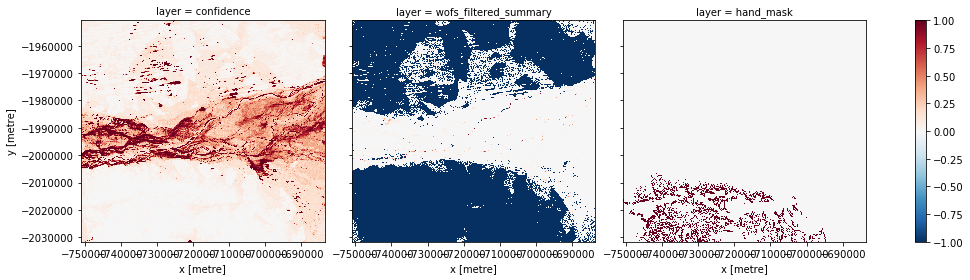

In [21]:
wofs.to_array(dim='layer').plot(col='layer',figsize= (15,4));

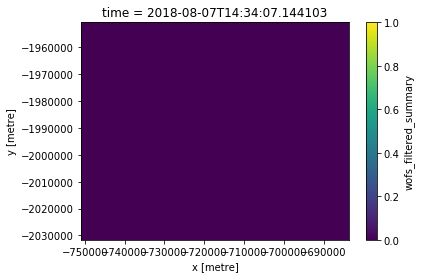

In [22]:
(wofs.wofs_filtered_summary.where(wofs.hand_mask) > 0).plot();